### This notebook contains the codes to generate all the plots used in the manuscript.
### Author: Chop Yan Lee

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import sqlalchemy, db_utils, glob, os, requests, itertools, re, shutil
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from statannotations.Annotator import Annotator
colors = sns.color_palette("hls",14)
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("colorblind")
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
bbox_to_anchor =(1, 1)
global_color = 'tab:grey'
connect = db_utils.get_connection()
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_extensions/AF2_MMv2.3/'
con = db_utils.get_connection()

In [2]:
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,change_markersize=False):
    global global_fontsize
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both',labelsize=global_fontsize)
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both',labelsize=global_fontsize)
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
    if change_markersize:
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    plt.tick_params(axis= 'both', labelsize= global_fontsize)

----
### Gather and preprocess the data needed for plotting later

In [3]:
# read in a list of DMI types so that I can parse the dmi names out of the prediction name
query = """select distinct dmi_type from chopyan_db.AF2_DMI_structure_PRS where for_AF2_benchmark = 1;"""
dmi_types = pd.read_sql_query(query,con=con)
dmi_types = dmi_types['dmi_type'].to_list()
dmi_types

['DEG_APCC_KENBOX_2',
 'DEG_COP1_1',
 'DEG_Kelch_Keap1_1',
 'DEG_Kelch_Keap1_2',
 'DEG_MDM2_SWIB_1',
 'DEG_SCF_COI1_1',
 'DEG_SCF_TIR1_1',
 'DEG_SIAH_1',
 'DEG_SPOP_SBC_1',
 'DOC_AGCK_PIF_3',
 'DOC_ANK_TNKS_1',
 'DOC_CYCLIN_RxL_1',
 'DOC_GSK3_Axin_1',
 'DOC_MAPK_DCC_7',
 'DOC_MAPK_GRA24_9',
 'DOC_MAPK_HePTP_8',
 'DOC_MAPK_JIP1_4',
 'DOC_MAPK_MEF2A_6',
 'DOC_MAPK_NFAT4_5',
 'DOC_MAPK_RevD_3',
 'DOC_PP1_MyPhoNE_1',
 'DOC_PP1_RVXF_1',
 'DOC_PP1_SILK_1',
 'DOC_PP2B_PxIxI_1',
 'DOC_SPAK_OSR1_1',
 'DOC_USP7_MATH_1',
 'DOC_USP7_MATH_2',
 'DOC_USP7_UBL2_3',
 'LIG_14-3-3_ChREBP_3',
 'LIG_Actin_RPEL_3',
 'LIG_Actin_WH2_1',
 'LIG_Actin_WH2_2',
 'LIG_ANK_PxLPxL_1',
 'LIG_AP2alpha_1',
 'LIG_AP2alpha_2',
 'LIG_APCC_ABBA_1',
 'LIG_ARL_BART_1',
 'LIG_BH_BH3_1',
 'LIG_BIR_III_2',
 'LIG_BIR_III_3',
 'LIG_CaM_IQ_9',
 'LIG_CAP-Gly_1',
 'LIG_CAP-Gly_2',
 'LIG_CID_NIM_1',
 'LIG_Clathr_ClatBox_1',
 'LIG_Clathr_ClatBox_2',
 'LIG_CNOT1_NIM_1',
 'LIG_CORNRBOX',
 'LIG_CSL_BTD_1',
 'LIG_deltaCOP1_diTrp_1',
 'LIG_

In [4]:
def parse_prediction_name(prediction_name,DMI_name_list):
    """Parse out different components in the standard name for a minimal DMI prediction (e.g. run51_DEG_APCC_KENBOX_2_MFL_DFL)

    Args:
        prediction_name (str): Name of the folder containing the AlphaFold predicted structure
        DMI_name_list (list of str): A list of DMI types

    Returns:
        run_id (str): Run ID
        dmi_name (str): Name of DMI type
        seq_annot (str): start and end of the extended model (e.g. M31_M45_Dmin)
    """
    splits = prediction_name.split('_')
    run_id = splits[0]
    temp = '_'.join(splits[1:])
    for dmi_name in DMI_name_list:
        match = re.search(dmi_name,temp)
        if match is not None:
            seq_annot = temp[match.end()+1:]
            return [run_id, dmi_name]
        
query = f"""select * from chopyan_db.AlphaFold_prediction_result
where run_id in ('run51') and project_name = 'AlphaFold_benchmark'"""

ext_df = pd.read_sql_query(query,con=con)

ext_df[['run_id','dmi_name']] = ext_df.apply(lambda x: parse_prediction_name(x['prediction_name'],dmi_types),
                                            axis=1,result_type='expand')
ext_df

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,align_score_domain,num_align_resi_domain,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat,dmi_name
0,AlphaFold_benchmark,run51_DEG_APCC_KENBOX_2_M15_M39_D1_D499,run51,499,25,ranked_0,0.693907,97.205000,87.086999,93.591428,...,1681.0,312.0,0.624025,0.863402,94.356000,0.961,0.422,0.580,0.107,DEG_APCC_KENBOX_2
1,AlphaFold_benchmark,run51_DEG_APCC_KENBOX_2_M15_M39_D1_D499,run51,499,25,ranked_1,0.690820,97.127778,86.359001,93.281786,...,1681.0,312.0,0.539758,0.830100,93.568001,0.955,0.363,0.509,0.111,DEG_APCC_KENBOX_2
2,AlphaFold_benchmark,run51_DEG_APCC_KENBOX_2_M15_M39_D1_D499,run51,499,25,ranked_2,0.685654,96.652727,79.507000,91.294688,...,1681.0,312.0,0.596557,0.806905,93.240001,0.971,0.448,0.574,0.037,DEG_APCC_KENBOX_2
3,AlphaFold_benchmark,run51_DEG_APCC_KENBOX_2_M15_M39_D1_D499,run51,499,25,ranked_3,0.678514,96.778333,82.695000,91.748571,...,1681.0,312.0,0.612031,0.788664,92.050000,0.965,0.385,0.569,0.107,DEG_APCC_KENBOX_2
4,AlphaFold_benchmark,run51_DEG_APCC_KENBOX_2_M15_M39_D1_D499,run51,499,25,ranked_4,0.652961,96.299999,78.545000,89.958928,...,1681.0,312.0,0.597260,0.798899,90.378000,0.972,0.314,0.563,0.074,DEG_APCC_KENBOX_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3446,AlphaFold_benchmark,run51_TRG_AP2beta_CARGO_1_Mmin_DFL,run51,937,11,ranked_0,0.854484,92.240666,78.001111,86.900833,...,1224.0,233.0,0.552314,1.355807,78.121819,0.956,0.387,0.578,0.033,TRG_AP2beta_CARGO_1
3447,AlphaFold_benchmark,run51_TRG_AP2beta_CARGO_1_Mmin_DFL,run51,937,11,ranked_1,0.817379,88.862857,67.481111,80.496087,...,1224.0,233.0,0.961719,1.611342,67.528182,0.943,0.378,1.007,0.097,TRG_AP2beta_CARGO_1
3448,AlphaFold_benchmark,run51_TRG_AP2beta_CARGO_1_Mmin_DFL,run51,937,11,ranked_2,0.803851,90.937334,69.568748,83.504783,...,1224.0,233.0,0.680285,1.463675,68.840908,0.947,0.366,0.721,0.034,TRG_AP2beta_CARGO_1
3449,AlphaFold_benchmark,run51_TRG_AP2beta_CARGO_1_Mmin_DFL,run51,937,11,ranked_3,0.745026,89.183125,50.857500,76.407917,...,1224.0,233.0,0.850946,1.558591,50.104545,0.917,0.533,0.824,0.129,TRG_AP2beta_CARGO_1


In [5]:
# check how predictions did not go through as some long predictions are tricky
ext_df[ext_df['model_id'] == 'Prediction failed'].shape

(16, 28)

In [6]:
# I made the mistake of duplicating some extensions as full length because some proteins after extension becomes
# full length, these should be de-duplicated
# I also only work with the best model as selected by the least RMSD_all_atom_peptide per predicton,
# the de-duplication will also filter for best model per prediction
final_df = ext_df.sort_values(['RMSD_all_atom_peptide'],ascending=True).drop_duplicates(subset=['dmi_name','chainA_length',
                                                                           'chainB_length'],keep='first').copy()
final_df.reset_index(drop=True,inplace=True)
print(final_df.shape)

(703, 28)


In [7]:
# create motif extension step index 
# chainB is always the motif chain 
temp = final_df.drop_duplicates(subset=['dmi_name','chainB_length']).copy()
motif_ext_index_df = temp.sort_values(['dmi_name','chainB_length'])[['dmi_name','chainB_length']].copy()
motif_ext_index_df['motif_ext_index'] = [i for v in motif_ext_index_df.groupby('dmi_name').size().values for i in range(0,v)]
motif_ext_index_df.reset_index(drop=True,inplace=True)
motif_ext_index_df

,dmi_name,chainB_length,motif_ext_index
0,DEG_APCC_KENBOX_2,5,0
1,DEG_APCC_KENBOX_2,15,1
2,DEG_APCC_KENBOX_2,25,2
3,DEG_APCC_KENBOX_2,45,3
4,DEG_APCC_KENBOX_2,57,4
...,...,...,...
229,TRG_AP2beta_CARGO_1,55,2
230,TRG_AP2beta_CARGO_1,97,3
231,TRG_AP2beta_CARGO_1,119,4
232,TRG_AP2beta_CARGO_1,271,5


motif_ext_index 6 as the full length

In [8]:
# create domain extension step index 
# chainA is always the domain chain 
temp = final_df.drop_duplicates(subset=['dmi_name','chainA_length']).copy()
domain_ext_index_df = temp.sort_values(['dmi_name','chainA_length'])[['dmi_name','chainA_length']].copy()
domain_ext_index_df['domain_ext_index'] = [i for v in domain_ext_index_df.groupby('dmi_name').size().values for i in range(0,v)]
domain_ext_index_df.reset_index(drop=True,inplace=True)
domain_ext_index_df

,dmi_name,chainA_length,domain_ext_index
0,DEG_APCC_KENBOX_2,307,0
1,DEG_APCC_KENBOX_2,499,1
2,DEG_Kelch_Keap1_1,280,0
3,DEG_Kelch_Keap1_1,330,1
4,DEG_Kelch_Keap1_1,450,2
...,...,...,...
107,LIG_WW_1,438,1
108,TRG_AP2beta_CARGO_1,232,0
109,TRG_AP2beta_CARGO_1,396,1
110,TRG_AP2beta_CARGO_1,934,2


domain_ext_index 3 as the full length

In [9]:
final_df = pd.merge(final_df,domain_ext_index_df,how='outer',on=['dmi_name','chainA_length'])
final_df = pd.merge(final_df,motif_ext_index_df,how='outer',on=['dmi_name','chainB_length'])
final_df

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat,dmi_name,domain_ext_index,motif_ext_index
0,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_D1_D204,run51,204,15,ranked_3,0.767290,92.155000,72.967143,83.760313,...,0.320134,0.430814,93.810001,0.969,0.314,0.308,0.208,DOC_USP7_MATH_1,1,1
1,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_Dmin,run51,138,15,ranked_1,0.842477,92.217895,76.384168,86.088710,...,0.363519,0.478511,93.482001,0.966,0.350,0.323,0.208,DOC_USP7_MATH_1,0,1
2,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_D1_D528,run51,528,15,ranked_2,0.806106,89.922353,67.459167,80.627241,...,0.394953,0.510463,86.636000,0.966,0.348,0.308,0.174,DOC_USP7_MATH_1,2,1
3,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_DFL,run51,1102,15,ranked_1,0.804861,85.344286,62.245833,76.944849,...,0.394756,0.564259,80.498000,0.961,0.395,0.371,0.208,DOC_USP7_MATH_1,3,1
4,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M367_M431_D1_D204,run51,204,65,ranked_1,0.639066,93.810000,79.608462,88.820270,...,0.409387,0.465894,96.214001,0.969,0.313,0.367,0.174,DOC_USP7_MATH_1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_MFL_Dmin,run51,432,292,ranked_4,0.269018,65.787500,28.328286,49.191646,...,18.786930,19.329712,26.486000,0.066,8.789,18.799,1.000,LIG_CNOT1_NIM_1,0,6
699,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_MFL_D1544_D2376,run51,833,292,ranked_3,0.259305,83.642308,25.267391,56.241837,...,20.034286,19.930250,25.110000,0.061,8.519,20.063,1.000,LIG_CNOT1_NIM_1,1,6
700,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_Mmin_D1377_D2376,run51,1000,10,ranked_0,0.562944,75.967692,29.968571,59.868000,...,14.524009,14.437459,29.346000,0.100,6.871,14.546,1.000,LIG_CNOT1_NIM_1,2,0
701,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_Mmin_D1544_D2376,run51,833,10,ranked_2,0.575764,77.844668,32.111250,61.937392,...,14.926224,14.601132,31.607000,0.096,7.001,14.947,1.000,LIG_CNOT1_NIM_1,1,0


### We later realized that some full length extensions (6th for motif extension and 3rd for domain extension) is marginal compared to the previous extension step. I have to manually check these cases and have them excluded from the analysis since the extensions are marginal and do not really count as meaningful extensions.

In [10]:
motif_ext_index_df.groupby('dmi_name').agg({'chainB_length':lambda x: ','.join(map(str,x)),
                                            'motif_ext_index':lambda x: ','.join(map(str,x))})

,chainB_length,motif_ext_index
dmi_name,,
DEG_APCC_KENBOX_2,"5,15,25,45,57,189,1050","0,1,2,3,4,5,6"
DEG_Kelch_Keap1_1,"6,18,30,54,78,568,605","0,1,2,3,4,5,6"
DEG_MDM2_SWIB_1,"8,24,40,58,74,298,393","0,1,2,3,4,5,6"
DEG_SIAH_1,"9,27,45,81,117,166,228","0,1,2,3,4,5,6"
DOC_ANK_TNKS_1,"8,24,40,72,104,322,350","0,1,2,3,4,5,6"
DOC_MAPK_JIP1_4,"7,21,35,63,91,427,455","0,1,2,3,4,5,6"
DOC_SPAK_OSR1_1,"5,15,25,45,65,801,1243","0,1,2,3,4,5,6"
DOC_USP7_MATH_1,"5,15,25,45,65,202,491","0,1,2,3,4,5,6"
DOC_USP7_UBL2_3,"5,15,25,37,42,682,1616","0,1,2,3,4,5,6"


Some full length motif extensions (step 6), is marginally different from step 5 that includes the neighboring domain. Katja said that those motif extension step 6 with less than 20 residues extended on either N or C terminus should be excluded from step 6. They are as follow:

- LIG_CNOT1_NIM_1
- LIG_OCRL_FandH_1
- LIG_PCNA_PIPBox_1
- LIG_RPA_C_Vert
- LIG_TRFH_1

In [11]:
# prepare the indices of 6th motif extension step that will be excluded from analysis later
dmi_6th_motif_ext_marginal = ['LIG_CNOT1_NIM_1','LIG_OCRL_FandH_1','LIG_PCNA_PIPBox_1','LIG_RPA_C_Vert',
                             'LIG_TRFH_1']
dmi_6th_motif_ext_marginal_ind = final_df[(final_df['dmi_name'].isin(dmi_6th_motif_ext_marginal)) & (final_df['motif_ext_index'] == 6)].index
len(dmi_6th_motif_ext_marginal_ind)

14

In [12]:
domain_ext_index_df.groupby('dmi_name').agg({'chainA_length':lambda x: ','.join(map(str,x)),
                                            'domain_ext_index':lambda x: ','.join(map(str,x))})

,chainA_length,domain_ext_index
dmi_name,,
DEG_APCC_KENBOX_2,"307,499","0,1"
DEG_Kelch_Keap1_1,"280,330,450,624","0,1,2,3"
DEG_MDM2_SWIB_1,"75,290,337,491","0,1,2,3"
DEG_SIAH_1,"188,282","0,1"
DOC_ANK_TNKS_1,"155,199,352,1166","0,1,2,3"
DOC_MAPK_JIP1_4,"351,464","0,1"
DOC_SPAK_OSR1_1,"57,227,521,527","0,1,2,3"
DOC_USP7_MATH_1,"138,204,528,1102","0,1,2,3"
DOC_USP7_UBL2_3,"245,338,893,1102","0,1,2,3"


After manual checking, the following DMI's domain extension step 3 will be excluded because their full length extensions differ marginally to that of domain extension step 2 (less than 20 residues on N or C terminal of the 2nd domain extension):
- DOC_SPAK_OSR1_1, domain ext 3
- LIG_TRFH_1, domain ext 3
- TRG_AP2beta_CARGO_1, domain ext 3

LIG_HOMEOBOX has 29 residue extension on the N terminus as the third domain extension step and that makes it okay to be included in the analysis.

In [13]:
# prepare the indices of 3rd domain extension step that will be excluded from analysis later
dmi_3rd_domain_ext_marginal = ['DOC_SPAK_OSR1_1','LIG_TRFH_1','TRG_AP2beta_CARGO_1']
dmi_3rd_domain_ext_marginal_ind = final_df[(final_df['dmi_name'].isin(dmi_3rd_domain_ext_marginal)) & (final_df['domain_ext_index'] == 3)].index
len(dmi_3rd_domain_ext_marginal_ind)

19

In [14]:
# some indices are repeated in 3rd domain extension and 6th motif extension exclusion
# so make a union of the two lists first
len(set(dmi_3rd_domain_ext_marginal_ind).union(set(dmi_6th_motif_ext_marginal_ind)))

32

In [15]:
# exclude the predictions involving 3rd domain extension that marginally extend the protein
final_df.drop(index=set(dmi_3rd_domain_ext_marginal_ind).union(set(dmi_6th_motif_ext_marginal_ind)),inplace=True)
final_df.reset_index(drop=True,inplace=True)
print(final_df.shape)
final_df

(671, 30)


,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat,dmi_name,domain_ext_index,motif_ext_index
0,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_D1_D204,run51,204,15,ranked_3,0.767290,92.155000,72.967143,83.760313,...,0.320134,0.430814,93.810001,0.969,0.314,0.308,0.208,DOC_USP7_MATH_1,1,1
1,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_Dmin,run51,138,15,ranked_1,0.842477,92.217895,76.384168,86.088710,...,0.363519,0.478511,93.482001,0.966,0.350,0.323,0.208,DOC_USP7_MATH_1,0,1
2,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_D1_D528,run51,528,15,ranked_2,0.806106,89.922353,67.459167,80.627241,...,0.394953,0.510463,86.636000,0.966,0.348,0.308,0.174,DOC_USP7_MATH_1,2,1
3,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_DFL,run51,1102,15,ranked_1,0.804861,85.344286,62.245833,76.944849,...,0.394756,0.564259,80.498000,0.961,0.395,0.371,0.208,DOC_USP7_MATH_1,3,1
4,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M367_M431_D1_D204,run51,204,65,ranked_1,0.639066,93.810000,79.608462,88.820270,...,0.409387,0.465894,96.214001,0.969,0.313,0.367,0.174,DOC_USP7_MATH_1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_M30_M59_D1377_D2376,run51,1000,30,ranked_3,0.422069,74.148999,30.209000,52.178999,...,16.797138,17.212463,30.992999,0.080,7.836,16.830,1.000,LIG_CNOT1_NIM_1,2,1
667,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_M30_M59_D1544_D2376,run51,833,30,ranked_4,0.420936,71.400000,33.881539,55.666452,...,17.497913,17.666700,33.797000,0.075,7.808,17.546,1.000,LIG_CNOT1_NIM_1,1,1
668,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_Mmin_D1377_D2376,run51,1000,10,ranked_0,0.562944,75.967692,29.968571,59.868000,...,14.524009,14.437459,29.346000,0.100,6.871,14.546,1.000,LIG_CNOT1_NIM_1,2,0
669,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_Mmin_D1544_D2376,run51,833,10,ranked_2,0.575764,77.844668,32.111250,61.937392,...,14.926224,14.601132,31.607000,0.096,7.001,14.947,1.000,LIG_CNOT1_NIM_1,1,0


In [16]:
# make a copy of the final_df to work with
temp = final_df.copy()

# make a summary of the number of sample size in each extension step pairings
summary = temp.groupby(['domain_ext_index','motif_ext_index']).size().reset_index(name='size').pivot(index='motif_ext_index',
                                                                                              columns='domain_ext_index')

# fill 0x0 with the number of DMIs selected for extension
summary.iloc[0,0] = len(temp.dmi_name.unique())
summary = summary.astype('int')
summary

size            
domain_ext_index    0   1   2   3
motif_ext_index                  
0                  34  34  22  19
1                  34  34  22  17
2                  34  34  22  17
3                  34  34  21  16
4                  33  33  21  15
5                  33  33  21  15
6                  26  25  13   9

Some files are not predicted, as checked before. I want to know how many files are missing in extension pairs.
----
Predicted files

In [17]:
# make a copy of the final_df to work with
temp = final_df[final_df['model_id'] != 'Prediction failed'].copy()

# make a summary of the number of sample size in each extension step pairings
summary = temp.groupby(['domain_ext_index','motif_ext_index']).size().reset_index(name='size').pivot(index='motif_ext_index',
                                                                                              columns='domain_ext_index')

# fill 0x0 with the number of DMIs selected for extension
summary.iloc[0,0] = len(temp.dmi_name.unique())
summary = summary.astype('int')
summary

size            
domain_ext_index    0   1   2   3
motif_ext_index                  
0                  34  34  21  17
1                  34  34  21  17
2                  34  34  21  17
3                  34  33  20  16
4                  33  33  20  15
5                  32  32  19  15
6                  26  23  12   8

Files failed to be predicted

In [18]:
# make a copy of the final_df to work with
temp = final_df[final_df['model_id'] == 'Prediction failed'].copy()

# make a summary of the number of sample size in each extension step pairings
summary = temp.groupby(['domain_ext_index','motif_ext_index']).size().reset_index(name='size').pivot(index='motif_ext_index',
                                                                                              columns='domain_ext_index')

# fill NaNs with 0
summary.fillna(0,inplace=True)
summary = summary.astype('int')
summary

size         
domain_ext_index    0  1  2  3
motif_ext_index               
0                   0  0  1  2
1                   0  0  1  0
2                   0  0  1  0
3                   0  1  1  0
4                   0  0  1  0
5                   1  1  2  0
6                   0  2  1  1

In [19]:
# finally, work with only those that are successfully predicted
final_df = final_df[final_df['model_id'] != 'Prediction failed'].copy()
final_df.shape

(655, 30)

### After checking manually, we decided to exclude the following DMI types from extension analysis because of the following reason:
- DEG_APCC_KENBOX: has a second known ELM instance (303AKENE307) that upon extension AF puts this motif instead to the interface.
- LIG_Pex14_3: upon full length extension, an ELM instance from another ELM class LIG_Pex14_1 was put at the interface. The motif protein extended is P50542 (PEX5), and it has quite some ELM instances involved in Pex biology. The one put at the interface is 308WLSDY312 -> load /Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/run46/run46_LIG_Pex14_3_MFL_DFL/ranked_2_superimpose.pse
- LIG_GYF: We used the ELM annotated structure 1L2Z as the solved model for superimposition but it seems like ELM DB made a mistake in annotating it as region 281-289 of P06729 when it actually is region 295-303 of the same protein. This mistake is corrected when we manually annotated the minimal interacting region. Nonetheless, upon extension, AF sees region 281-289 and puts it at the interface instead. So I think the main problem is that these repeated occurrence of known motif is problematic to our extension analysis. -> load /Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/run39/run39_LIG_GYF_M277_M321_D1_D341/ranked_1_superimpose.pse

In [20]:
# exclude the problematic DMI type and their extensions
print(final_df.shape)
excluded_dmi = ['DEG_APCC_KENBOX_2','LIG_Pex14_3','LIG_GYF']
final_df = final_df[final_df['dmi_name'].isin(['DEG_APCC_KENBOX_2','LIG_Pex14_3','LIG_GYF'])==False].copy()
print(final_df.shape)
# reset the index of final_df just in case
final_df.reset_index(drop=True,inplace=True)

(655, 30)
(616, 30)


Check again the number of predictions that we still have in every motif-domain extension pair

In [21]:
# make a copy of the final_df to work with
temp = final_df.copy()

# make a summary of the number of sample size in each extension step pairings
summary = temp.groupby(['domain_ext_index','motif_ext_index']).size().reset_index(name='size').pivot(index='motif_ext_index',
                                                                                              columns='domain_ext_index')

# fill 0x0 with the number of DMIs selected for extension
summary.iloc[0,0] = len(temp.dmi_name.unique())
summary = summary.astype('int')
summary

size            
domain_ext_index    0   1   2   3
motif_ext_index                  
0                  31  31  21  17
1                  31  31  21  17
2                  31  31  21  17
3                  31  30  20  16
4                  30  30  20  15
5                  29  29  19  15
6                  23  20  12   8

### Retrieve minimal fragment information for analysis on how the extensions affect their prediction accuracy compared to minimal fragment predictions

In [22]:
def parse_prediction_name(prediction_name):
    """Parse out different components in the standard name for a minimal DMI prediction (e.g. run37_DEG_APCC_KENBOX_2_4GGD)

    Args:
        prediction_name (str): Name of the folder containing the AlphaFold predicted structure

    Returns:
        run_id (str): Run ID
        dmi_name (str): Name of DMI type
        pdb_id (str): PDB ID
    """
    splits = prediction_name.split('_')
    run_id = splits[0]
    dmi_name = '_'.join(splits[1:-1])
    pdb_id = splits[-1]
    return [run_id, dmi_name, pdb_id]

min_df = pd.read_csv('/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/run48/run48_template_indep_dep_info.tsv',
                sep='\t',index_col=0)

min_df[['run_id','dmi_name','pdb_id']] = min_df.apply(lambda x: parse_prediction_name(x['prediction_name']),
                                                                        axis=1,result_type='expand')
min_df = min_df[['dmi_name','RMSD_all_atom_peptide','DockQ','model_confidence','intf_avg_plddt',
                 'chainB_intf_avg_plddt','pDockQ']].copy()
min_df = min_df.sort_values(['RMSD_all_atom_peptide'],ascending=True).drop_duplicates(subset=['dmi_name'],keep='first').copy()
print(min_df.shape)

# filter for only DMI types that are used for extensions
min_df = min_df[min_df['dmi_name'].isin(final_df.dmi_name.unique())].copy()
print(min_df.shape)

(136, 7)
(31, 7)


In [23]:
condlist = [min_df['RMSD_all_atom_peptide'] <= 2,
           (min_df['RMSD_all_atom_peptide'] > 2) & (min_df['RMSD_all_atom_peptide'] <= 5),
            (min_df['RMSD_all_atom_peptide'] > 5) & (min_df['RMSD_all_atom_peptide'] <= 15),
            min_df['RMSD_all_atom_peptide'] > 15]
choicelist = ['correct_sidechain','correct_backbone','correct_pocket','wrong_pocket']
min_df['RMSD_all_atom_peptide_classification'] = np.select(condlist,choicelist)

min_df.groupby('RMSD_all_atom_peptide_classification').size()

RMSD_all_atom_peptide_classification
correct_backbone      6
correct_pocket       10
correct_sidechain    15
dtype: int64

In [24]:
# join RMSD_domain and RMSD_peptide with agg_min_df so that I can calculate the difference of RMSD after extension
merged_df = pd.merge(final_df, min_df, how='inner',on='dmi_name',suffixes=['','_min_frag'])

# calculate difference in peptide RMSD then the fold change
merged_df['RMSD_all_atom_peptide_fold_change'] = np.log2(merged_df['RMSD_all_atom_peptide_min_frag'] / merged_df['RMSD_all_atom_peptide'])

# calculate the change in DockQ after extension
merged_df['DockQ_ext-DockQ_min'] = merged_df['DockQ'] - merged_df['DockQ_min_frag']
merged_df

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,motif_ext_index,RMSD_all_atom_peptide_min_frag,DockQ_min_frag,model_confidence_min_frag,intf_avg_plddt_min_frag,chainB_intf_avg_plddt_min_frag,pDockQ_min_frag,RMSD_all_atom_peptide_classification,RMSD_all_atom_peptide_fold_change,DockQ_ext-DockQ_min
0,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_D1_D204,run51,204,15,ranked_3,0.767290,92.155000,72.967143,83.760313,...,1,0.670959,0.978,0.934844,96.759999,93.4560,0.225559,correct_sidechain,0.639159,-0.009
1,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_Dmin,run51,138,15,ranked_1,0.842477,92.217895,76.384168,86.088710,...,1,0.670959,0.978,0.934844,96.759999,93.4560,0.225559,correct_sidechain,0.487674,-0.012
2,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_D1_D528,run51,528,15,ranked_2,0.806106,89.922353,67.459167,80.627241,...,1,0.670959,0.978,0.934844,96.759999,93.4560,0.225559,correct_sidechain,0.394420,-0.012
3,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_DFL,run51,1102,15,ranked_1,0.804861,85.344286,62.245833,76.944849,...,1,0.670959,0.978,0.934844,96.759999,93.4560,0.225559,correct_sidechain,0.249867,-0.017
4,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M367_M431_D1_D204,run51,204,65,ranked_1,0.639066,93.810000,79.608462,88.820270,...,4,0.670959,0.978,0.934844,96.759999,93.4560,0.225559,correct_sidechain,0.526222,-0.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_M30_M59_Dmin,run51,432,30,ranked_2,0.425966,66.584737,31.838750,50.700857,...,1,13.382578,0.108,0.605383,63.407308,34.5725,0.040655,correct_pocket,-0.361259,-0.028
612,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_M30_M59_D1377_D2376,run51,1000,30,ranked_3,0.422069,74.148999,30.209000,52.178999,...,1,13.382578,0.108,0.605383,63.407308,34.5725,0.040655,correct_pocket,-0.363098,-0.028
613,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_M30_M59_D1544_D2376,run51,833,30,ranked_4,0.420936,71.400000,33.881539,55.666452,...,1,13.382578,0.108,0.605383,63.407308,34.5725,0.040655,correct_pocket,-0.400677,-0.033
614,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_Mmin_D1377_D2376,run51,1000,10,ranked_0,0.562944,75.967692,29.968571,59.868000,...,0,13.382578,0.108,0.605383,63.407308,34.5725,0.040655,correct_pocket,-0.109461,-0.008


In [25]:
# classify the RMSD peptide before extension (minimal)
condlist = [merged_df['RMSD_all_atom_peptide_min_frag'] <= 2,
           (merged_df['RMSD_all_atom_peptide_min_frag'] > 2) & (merged_df['RMSD_all_atom_peptide_min_frag'] <= 5),
            (merged_df['RMSD_all_atom_peptide_min_frag'] > 5) & (merged_df['RMSD_all_atom_peptide_min_frag'] <= 15),
            merged_df['RMSD_all_atom_peptide_min_frag'] > 15]
choicelist = ['correct_sidechain','correct_backbone','correct_pocket','wrong_pocket']
merged_df['RMSD_all_atom_peptide_classification_min_frag'] = np.select(condlist,choicelist)

merged_df

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,RMSD_all_atom_peptide_min_frag,DockQ_min_frag,model_confidence_min_frag,intf_avg_plddt_min_frag,chainB_intf_avg_plddt_min_frag,pDockQ_min_frag,RMSD_all_atom_peptide_classification,RMSD_all_atom_peptide_fold_change,DockQ_ext-DockQ_min,RMSD_all_atom_peptide_classification_min_frag
0,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_D1_D204,run51,204,15,ranked_3,0.767290,92.155000,72.967143,83.760313,...,0.670959,0.978,0.934844,96.759999,93.4560,0.225559,correct_sidechain,0.639159,-0.009,correct_sidechain
1,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_Dmin,run51,138,15,ranked_1,0.842477,92.217895,76.384168,86.088710,...,0.670959,0.978,0.934844,96.759999,93.4560,0.225559,correct_sidechain,0.487674,-0.012,correct_sidechain
2,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_D1_D528,run51,528,15,ranked_2,0.806106,89.922353,67.459167,80.627241,...,0.670959,0.978,0.934844,96.759999,93.4560,0.225559,correct_sidechain,0.394420,-0.012,correct_sidechain
3,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M392_M406_DFL,run51,1102,15,ranked_1,0.804861,85.344286,62.245833,76.944849,...,0.670959,0.978,0.934844,96.759999,93.4560,0.225559,correct_sidechain,0.249867,-0.017,correct_sidechain
4,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_M367_M431_D1_D204,run51,204,65,ranked_1,0.639066,93.810000,79.608462,88.820270,...,0.670959,0.978,0.934844,96.759999,93.4560,0.225559,correct_sidechain,0.526222,-0.009,correct_sidechain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_M30_M59_Dmin,run51,432,30,ranked_2,0.425966,66.584737,31.838750,50.700857,...,13.382578,0.108,0.605383,63.407308,34.5725,0.040655,correct_pocket,-0.361259,-0.028,correct_pocket
612,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_M30_M59_D1377_D2376,run51,1000,30,ranked_3,0.422069,74.148999,30.209000,52.178999,...,13.382578,0.108,0.605383,63.407308,34.5725,0.040655,correct_pocket,-0.363098,-0.028,correct_pocket
613,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_M30_M59_D1544_D2376,run51,833,30,ranked_4,0.420936,71.400000,33.881539,55.666452,...,13.382578,0.108,0.605383,63.407308,34.5725,0.040655,correct_pocket,-0.400677,-0.033,correct_pocket
614,AlphaFold_benchmark,run51_LIG_CNOT1_NIM_1_Mmin_D1377_D2376,run51,1000,10,ranked_0,0.562944,75.967692,29.968571,59.868000,...,13.382578,0.108,0.605383,63.407308,34.5725,0.040655,correct_pocket,-0.109461,-0.008,correct_pocket


----
### Finished pre-processing and prediction checking, start analyzing benchmark metrics

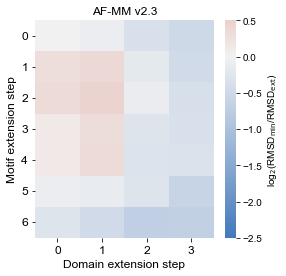

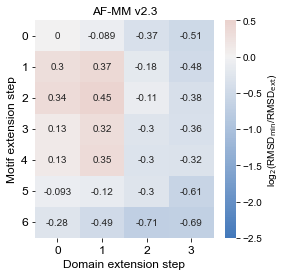

In [26]:
# pivot the table for heatmap plotting
temp = merged_df[['domain_ext_index','motif_ext_index','RMSD_all_atom_peptide_fold_change']].pivot_table(index='motif_ext_index',
                                                                                   columns='domain_ext_index',
                                                                                   values='RMSD_all_atom_peptide_fold_change',
                                                                                   aggfunc=np.mean).fillna(0).copy()

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(temp,annot=False,center=0,cmap=sns.diverging_palette(250, 18, as_cmap=True),vmin=-2.5,vmax=0.5,
           cbar_kws={'label': 'log$_{\mathrm{2}}$(RMSD$_{\mathrm{min}}$/RMSD$_{\mathrm{ext}}$)'})
plt.ylabel('Motif extension step',fontsize=global_fontsize)
plt.xlabel('Domain extension step',fontsize=global_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=global_fontsize)
plt.title('AF-MM v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}domain_motif_ext_peptide_fold_change_heatmap.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}domain_motif_ext_peptide_fold_change_heatmap.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(temp,annot=True,center=0,cmap=sns.diverging_palette(250, 18, as_cmap=True),vmin=-2.5,vmax=0.5,
           cbar_kws={'label': 'log$_{\mathrm{2}}$(RMSD$_{\mathrm{min}}$/RMSD$_{\mathrm{ext}}$)'})
plt.ylabel('Motif extension step',fontsize=global_fontsize)
plt.xlabel('Domain extension step',fontsize=global_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=global_fontsize)
plt.title('AF-MM v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}domain_motif_ext_peptide_fold_change_heatmap_annot.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}domain_motif_ext_peptide_fold_change_heatmap_annot.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

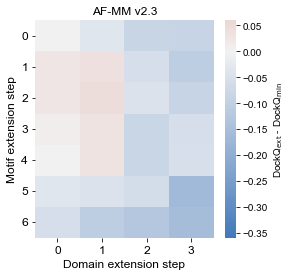

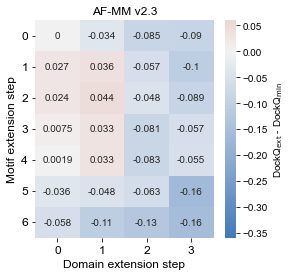

In [27]:
# pivot the table for heatmap plotting
temp = merged_df[['domain_ext_index','motif_ext_index','DockQ_ext-DockQ_min']].pivot_table(index='motif_ext_index',
                                                                                   columns='domain_ext_index',
                                                                                   values='DockQ_ext-DockQ_min',
                                                                                   aggfunc=np.mean).fillna(0).copy()

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(temp,annot=False,center=0,cmap=sns.diverging_palette(250, 18, as_cmap=True),vmin=-0.36,vmax=0.06,
           cbar_kws={'label': "DockQ$_{\mathrm{ext}}$ - DockQ$_{\mathrm{min}}$"})
plt.ylabel('Motif extension step',fontsize=global_fontsize)
plt.xlabel('Domain extension step',fontsize=global_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=global_fontsize)
plt.title('AF-MM v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}DockQ_ext-DockQ_min_heatmap.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}DockQ_ext-DockQ_min_heatmap.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(temp,annot=True,center=0,cmap=sns.diverging_palette(250, 18, as_cmap=True),vmin=-0.36,vmax=0.06,
           cbar_kws={'label': "DockQ$_{\mathrm{ext}}$ - DockQ$_{\mathrm{min}}$"})
plt.ylabel('Motif extension step',fontsize=global_fontsize)
plt.xlabel('Domain extension step',fontsize=global_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=global_fontsize)
plt.title('AF-MM v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}DockQ_ext-DockQ_min_heatmap_annot.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}DockQ_ext-DockQ_min_heatmap_annot.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

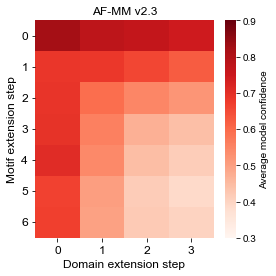

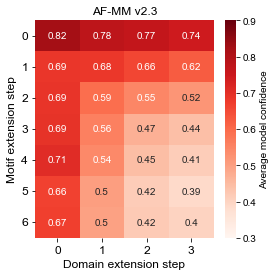

In [28]:
# pivot the table for heatmap plotting
temp = merged_df[['domain_ext_index','motif_ext_index','model_confidence']].pivot_table(index='motif_ext_index',
                                                                                   columns='domain_ext_index',
                                                                                   values='model_confidence',
                                                                                   aggfunc=np.mean).copy()

# calculate the value to fill for 0 x 0 extension
temp.fillna(np.mean(min_df.model_confidence),inplace=True)

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(temp,annot=False,cmap=sns.color_palette("Reds", as_cmap=True),vmin=0.3,vmax=0.9,
           cbar_kws={'label': 'Average model confidence'})
plt.ylabel('Motif extension step',fontsize=global_fontsize)
plt.xlabel('Domain extension step',fontsize=global_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=global_fontsize)
plt.title('AF-MM v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}domain_motif_ext_model_confidence_heatmap.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}domain_motif_ext_model_confidence_heatmap.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(temp,annot=True,cmap=sns.color_palette("Reds", as_cmap=True),vmin=0.3,vmax=0.9,
           cbar_kws={'label': 'Average model confidence'})
plt.ylabel('Motif extension step',fontsize=global_fontsize)
plt.xlabel('Domain extension step',fontsize=global_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=global_fontsize)
plt.title('AF-MM v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}domain_motif_ext_model_confidence_heatmap_annot.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}domain_motif_ext_model_confidence_heatmap_annot.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

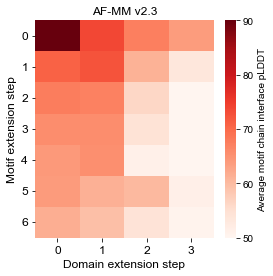

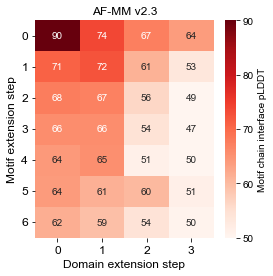

In [29]:
# pivot the table for heatmap plotting
temp = merged_df[['domain_ext_index','motif_ext_index','chainB_intf_avg_plddt']].pivot_table(index='motif_ext_index',
                                                                                   columns='domain_ext_index',
                                                                                   values='chainB_intf_avg_plddt',
                                                                                   aggfunc=np.mean).copy()

# calculate the value to fill for 0 x 0 extension
temp.fillna(np.mean(min_df.intf_avg_plddt),inplace=True)

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(temp,annot=False,cmap=sns.color_palette("Reds", as_cmap=True),vmin=50,vmax=90,
           cbar_kws={'ticks':[50,60,70,80,90],'label': 'Average motif chain interface pLDDT'})
plt.ylabel('Motif extension step',fontsize=global_fontsize)
plt.xlabel('Domain extension step',fontsize=global_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=global_fontsize)
plt.title('AF-MM v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}domain_motif_ext_chainB_intf_avg_plddt_heatmap.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}domain_motif_ext_chainB_intf_avg_plddt_heatmap.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(temp,annot=True,cmap=sns.color_palette("Reds", as_cmap=True),vmin=50,vmax=90,
           cbar_kws={'ticks':[50,60,70,80,90],'label': 'Motif chain interface pLDDT'})
plt.ylabel('Motif extension step',fontsize=global_fontsize)
plt.xlabel('Domain extension step',fontsize=global_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=global_fontsize)
plt.title('AF-MM v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}domain_motif_ext_chainB_intf_avg_plddt_heatmap_annot.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}domain_motif_ext_chainB_intf_avg_plddt_heatmap_annot.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

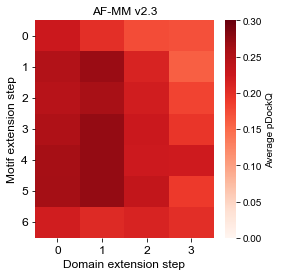

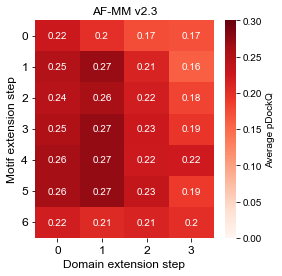

In [30]:
# pivot the table for heatmap plotting
temp = merged_df[['domain_ext_index','motif_ext_index','pDockQ']].pivot_table(index='motif_ext_index',
                                                                                   columns='domain_ext_index',
                                                                                   values='pDockQ',
                                                                                   aggfunc=np.mean).copy()

# calculate the value to fill for 0 x 0 extension
temp.fillna(np.mean(min_df.pDockQ),inplace=True)

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(temp,annot=False,cmap=sns.color_palette("Reds", as_cmap=True),vmin=0.0,vmax=0.3,
           cbar_kws={'label': 'Average pDockQ'})
plt.ylabel('Motif extension step',fontsize=global_fontsize)
plt.xlabel('Domain extension step',fontsize=global_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=global_fontsize)
plt.title('AF-MM v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}domain_motif_ext_pDockQ_heatmap.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}domain_motif_ext_pDockQ_heatmap.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(temp,annot=True,cmap=sns.color_palette("Reds", as_cmap=True),vmin=0.0,vmax=0.3,
           cbar_kws={'label': 'Average pDockQ'})
plt.ylabel('Motif extension step',fontsize=global_fontsize)
plt.xlabel('Domain extension step',fontsize=global_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=global_fontsize)
plt.title('AF-MM v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}domain_motif_ext_pDockQ_heatmap_annot.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}domain_motif_ext_pDockQ_heatmap_annot.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

In [31]:
merged_df[(merged_df['domain_ext_index'] == 3) & (merged_df['motif_ext_index'] == 6)]

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,RMSD_all_atom_peptide_min_frag,DockQ_min_frag,model_confidence_min_frag,intf_avg_plddt_min_frag,chainB_intf_avg_plddt_min_frag,pDockQ_min_frag,RMSD_all_atom_peptide_classification,RMSD_all_atom_peptide_fold_change,DockQ_ext-DockQ_min,RMSD_all_atom_peptide_classification_min_frag
26,AlphaFold_benchmark,run51_DOC_USP7_MATH_1_MFL_DFL,run51,1102,491,ranked_4,0.236641,60.057069,34.499615,47.975364,...,0.670959,0.978,0.934844,96.759999,93.456000,0.225559,correct_sidechain,-5.754083,-0.955,correct_sidechain
62,AlphaFold_benchmark,run51_DOC_ANK_TNKS_1_MFL_DFL,run51,1166,350,ranked_4,0.311376,72.051513,32.156786,55.543350,...,0.792328,0.979,0.934079,97.447200,94.977499,0.343941,correct_sidechain,0.138622,-0.013,correct_sidechain
81,AlphaFold_benchmark,run51_DEG_Kelch_Keap1_1_MFL_DFL,run51,624,605,ranked_3,0.594103,82.254615,49.846530,68.324824,...,0.939188,0.970,0.956363,97.330834,92.878334,0.341930,correct_sidechain,0.146494,-0.010,correct_sidechain
174,AlphaFold_benchmark,run51_DEG_MDM2_SWIB_1_MFL_DFL,run51,491,393,ranked_0,0.299249,53.680396,53.911579,53.792449,...,1.169641,0.917,0.875615,97.013809,94.691667,0.214832,correct_sidechain,0.187208,0.025,correct_sidechain
216,AlphaFold_benchmark,run51_LIG_HOMEOBOX_MFL_DFL,run51,430,301,ranked_2,0.477507,77.616316,70.950285,74.420274,...,5.707130,0.638,0.459158,73.505001,46.500000,0.028004,correct_pocket,2.477286,0.324,correct_pocket
258,AlphaFold_benchmark,run51_LIG_BIR_III_2_MFL_DFL,run51,497,416,ranked_1,0.480179,51.109891,51.345778,51.226538,...,1.167944,0.958,0.899659,97.851177,97.890001,0.197312,correct_sidechain,-0.073541,0.009,correct_sidechain
457,AlphaFold_benchmark,run51_LIG_LRP6_Inhibitor_1_MFL_DFL,run51,1613,266,ranked_1,0.457783,73.842131,52.785295,64.253750,...,6.047950,0.596,0.635894,75.346364,35.471667,0.060124,correct_pocket,-2.598363,-0.570,correct_pocket
570,AlphaFold_benchmark,run51_LIG_ULM_U2AF65_1_MFL_DFL,run51,475,639,ranked_2,0.366504,71.516979,58.490761,65.142447,...,5.785178,0.673,0.694331,84.597500,68.164445,0.101864,correct_pocket,-0.058835,-0.056,correct_pocket


In [32]:
# export the dataframe used for plotting for publication's supplemental table
temp = merged_df.copy()
temp['prediction_name'] = [pred_name.lstrip(f'{run_id}_') for pred_name, run_id in zip(temp['prediction_name'],
                                                                                temp['run_id'])]
print(temp.shape)
temp.to_csv('/Volumes/imb-luckgr/manuscripts/AlphaFold_paper/tables/MMv2.3_extended_DMI_prediction_raw.tsv',
         sep='\t',index=None)

(616, 40)
